In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Calculate Dark Channel

In [2]:
def get_dark_channel(img, wind_size):
    dark_channel = np.zeros((img.shape[0], img.shape[1]))
    img = cv2.copyMakeBorder(img,wind_size//2,wind_size//2,wind_size//2,wind_size//2,cv2.BORDER_CONSTANT,value=[255,255,255])
    no_rows = img.shape[0]
    no_cols = img.shape[1]
    min_channel = np.zeros((no_rows, no_cols))
    for row in range(no_rows):
        for col in range(no_cols):
            min_channel[row-wind_size//2][col-wind_size//2] = np.min(img[row,col,:])
    for row in range(wind_size//2, no_rows-wind_size//2):
        for col in range(wind_size//2, no_cols-wind_size//2):
            dark_channel[row-wind_size//2][col-wind_size//2] = np.min(min_channel[row-wind_size//2:row+wind_size//2,col-wind_size//2:col+wind_size//2])
    return dark_channel

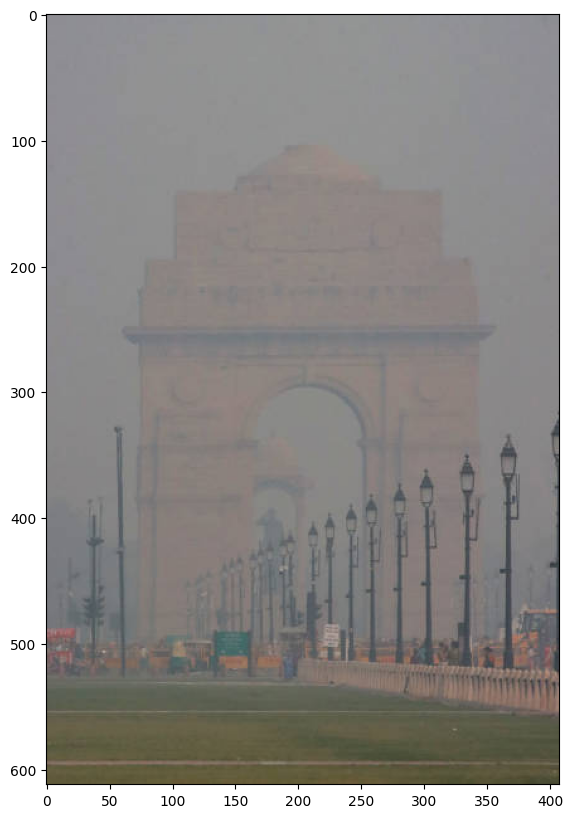

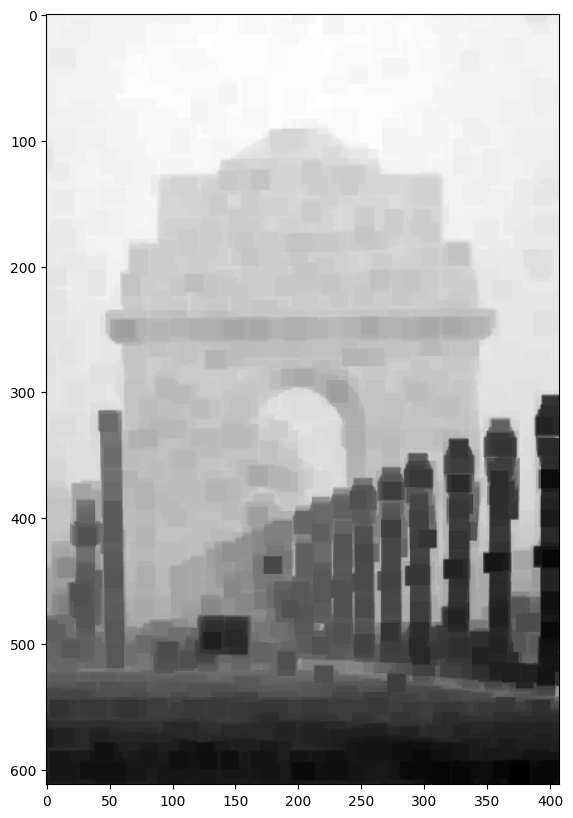

In [3]:
img = cv2.imread("/content/a.jpg")

plt.figure(figsize=(10,10))
plt.imshow(img[...,::-1])
plt.show()
dark_channel_img = get_dark_channel(img, 15)
dark_channel_img = dark_channel_img.astype('uint8')
plt.figure(figsize=(10,10))
plt.imshow(dark_channel_img,'gray')
plt.show()

# Estimate Atmospheric Light

In [4]:
def get_atm_light(im, dark_channel_img):
    img = im.copy()
    num_pixels = dark_channel_img.size
    num_brightest = num_pixels//1000
    haze_density_sort_idx = np.argsort(dark_channel_img,axis=None)[::-1]
    brightest = haze_density_sort_idx[0:num_brightest]
    brightest = np.unravel_index(brightest,dark_channel_img.shape)
    brightest_pixels = img[brightest]
    top_intensities = np.average(brightest_pixels, axis=1)
    max_intensity = np.argmax(top_intensities)
    A = brightest_pixels[max_intensity]
    img[brightest]=[255,0,0]
    row_min = np.min(brightest[0])
    row_max = np.max(brightest[0])
    col_min = np.min(brightest[1])
    col_max = np.max(brightest[1])
    cv2.rectangle(img, (col_min,row_min),(col_max,row_max),(0,0,255),thickness=1)
    #print(row_min,col_min,row_max,col_max)
    plt.figure(figsize=(10,10))
    plt.imshow(img[...,::-1])
    plt.show()
    return A

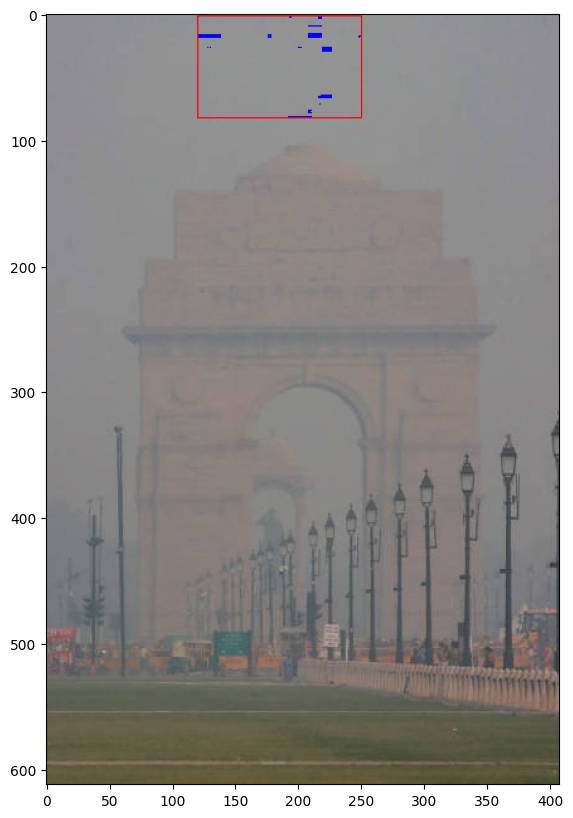

In [5]:
atm_light = get_atm_light(img,dark_channel_img)

# Estimate Transmission

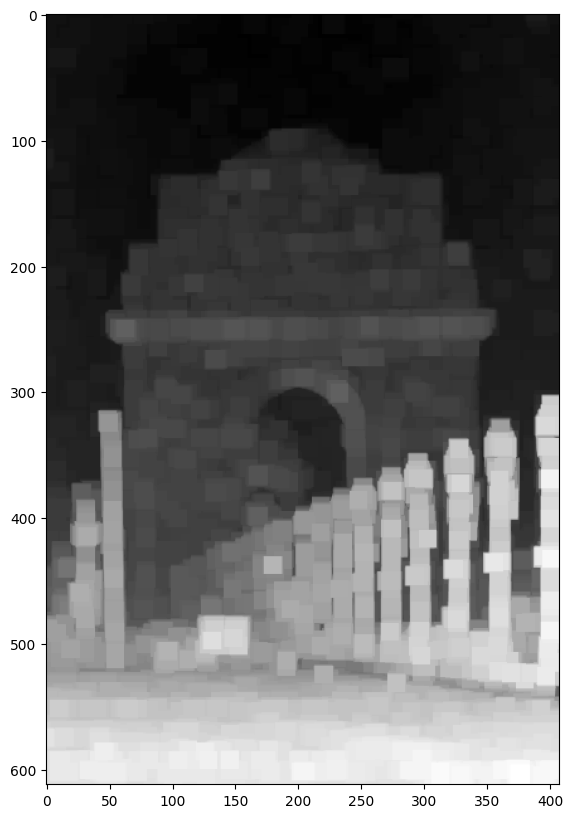

In [6]:
t_bar = get_dark_channel(img/atm_light,15)
trans_bar = 1-(0.85*t_bar)
plt.figure(figsize=(10,10))
plt.imshow(trans_bar,'gray')
plt.show()

# Transmission Refinement

In [7]:
def refine(img, transmission, radius, epsilon):
    mean_guide = cv2.blur(img,(radius,radius))
    mean_trans = cv2.blur(transmission,(radius,radius))
    mean_gt = cv2.blur(img * transmission, (radius,radius))

    a = mean_gt - mean_guide * mean_trans
    var_guide = cv2.blur(img * img,(radius,radius)) - (mean_guide * mean_guide)
    a = a/(var_guide + epsilon)
    b = mean_trans - a * mean_guide

    q = cv2.blur(a,(radius,radius)) * img + cv2.blur(b,(radius,radius))
    return q

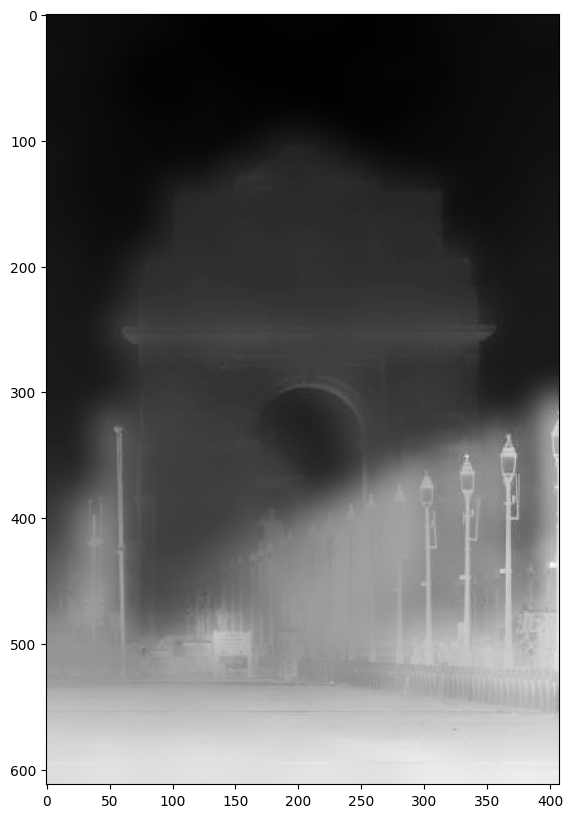

In [8]:
i=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)/255
t_refine = refine(i, trans_bar, 30, 0.0001)
plt.figure(figsize=(10,10))
plt.imshow(t_refine,'gray')
plt.show()

# Depth Map

In [9]:
def depth_map(t_refine, beta):
    return (-np.log(t_refine)/beta)

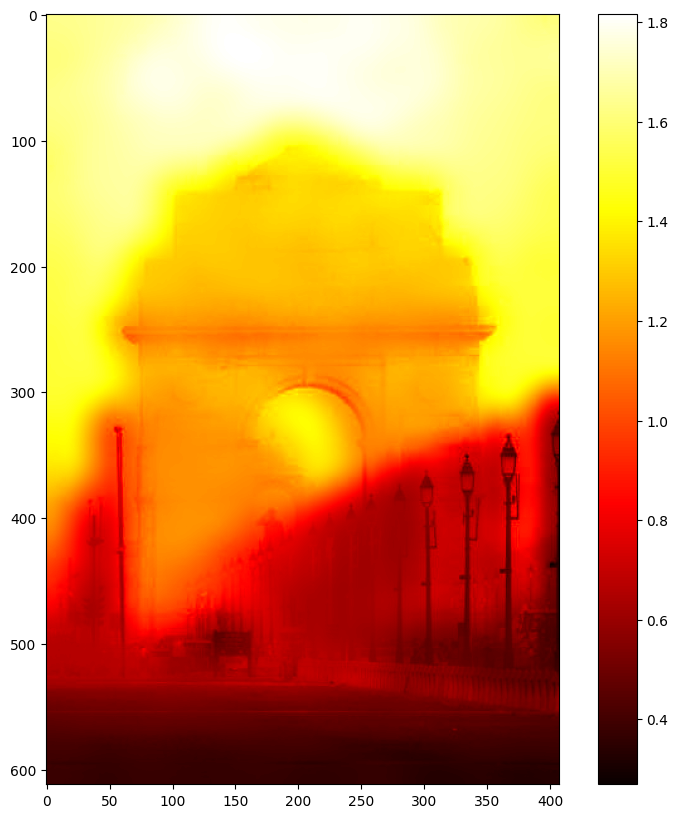

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(depth_map(t_refine, 1),'hot')
plt.colorbar()
plt.show()

# Recovering the Image

In [11]:
def recover_image(img, trans_bar, atm_light, t0):
    trans_recover = np.copy(trans_bar)
    trans_recover[trans_recover < t0] = t0
    J = np.zeros((img.shape))
    J[:,:,0] = ((img[:,:,0] - atm_light[0])/trans_recover) + atm_light[0]
    J[:,:,1] = ((img[:,:,1] - atm_light[1])/trans_recover) + atm_light[1]
    J[:,:,2] = ((img[:,:,2] - atm_light[2])/trans_recover) + atm_light[2]
    return J

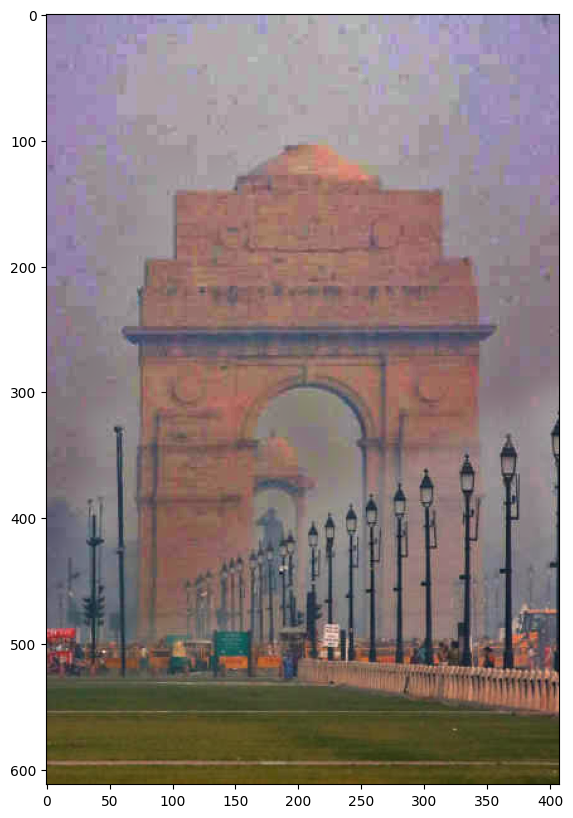

In [12]:
im = img.astype("double")
J = recover_image(im, t_refine, atm_light, 0.1)
J = ((J-np.min(J))/(np.max(J)-np.min(J)))*255
plt.figure(figsize=(10,10))
plt.imshow((np.uint8(J[...,::-1])))
plt.show()

# Color Balancing

In [13]:
def color_balance(img, s):
    out = np.copy(img)
    hist = np.zeros((256,1))
    no_of_pixels = img.shape[0] * img.shape[1]
    for i in range(3):
        channel_vals = img[:,:,i]
        for pixel_val in range(256):
            hist[pixel_val] = np.sum((channel_vals == pixel_val))
        for pixel_val in range(256):
            hist[pixel_val] = hist[pixel_val-1] + hist[pixel_val]
        Vmin = 0
        while (Vmin < 255 and hist[Vmin] <= no_of_pixels*s):
            Vmin += 1
        Vmax = 255
        while (Vmax > 0 and hist[Vmax] > no_of_pixels*(1-s)):
            Vmax -= 1
        channel_vals[channel_vals < Vmin] = Vmin
        channel_vals[channel_vals > Vmax] = Vmax
        out[:,:,i] = cv2.normalize(channel_vals, channel_vals.copy(), 0, 255, cv2.NORM_MINMAX)
    return out

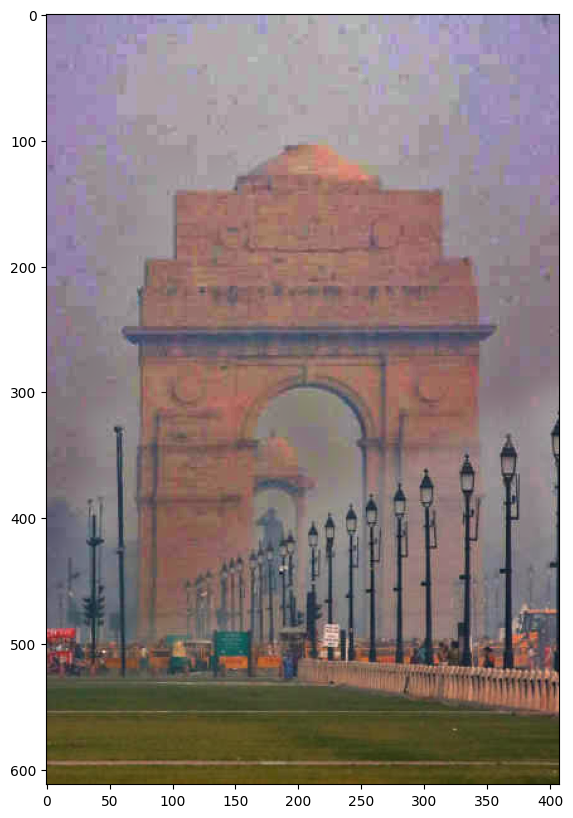

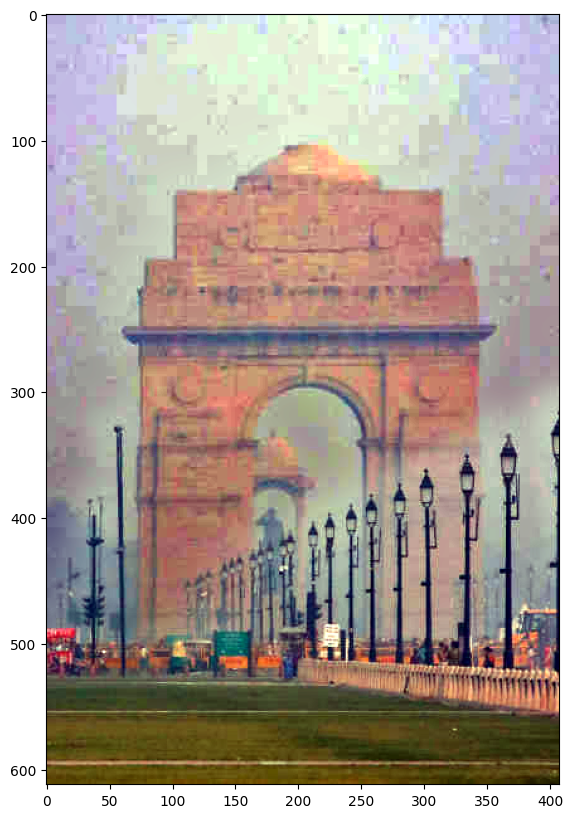

In [14]:
plt.figure(figsize=(10,10))
plt.imshow((np.uint8(J[...,::-1])))
plt.show()
cb_J = color_balance(np.uint8(J),0.005)
plt.figure(figsize=(10,10))
plt.imshow((np.uint8(cb_J[...,::-1])))
plt.show()

# Compare with Histogram Equalization

In [15]:
def histEqual(im):
    ycrcb = cv2.cvtColor(im, cv2.COLOR_BGR2YCrCb)
    ycrcb[:,:,0] = cv2.equalizeHist(ycrcb[:,:,0])
    restored = cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2BGR)
    return restored

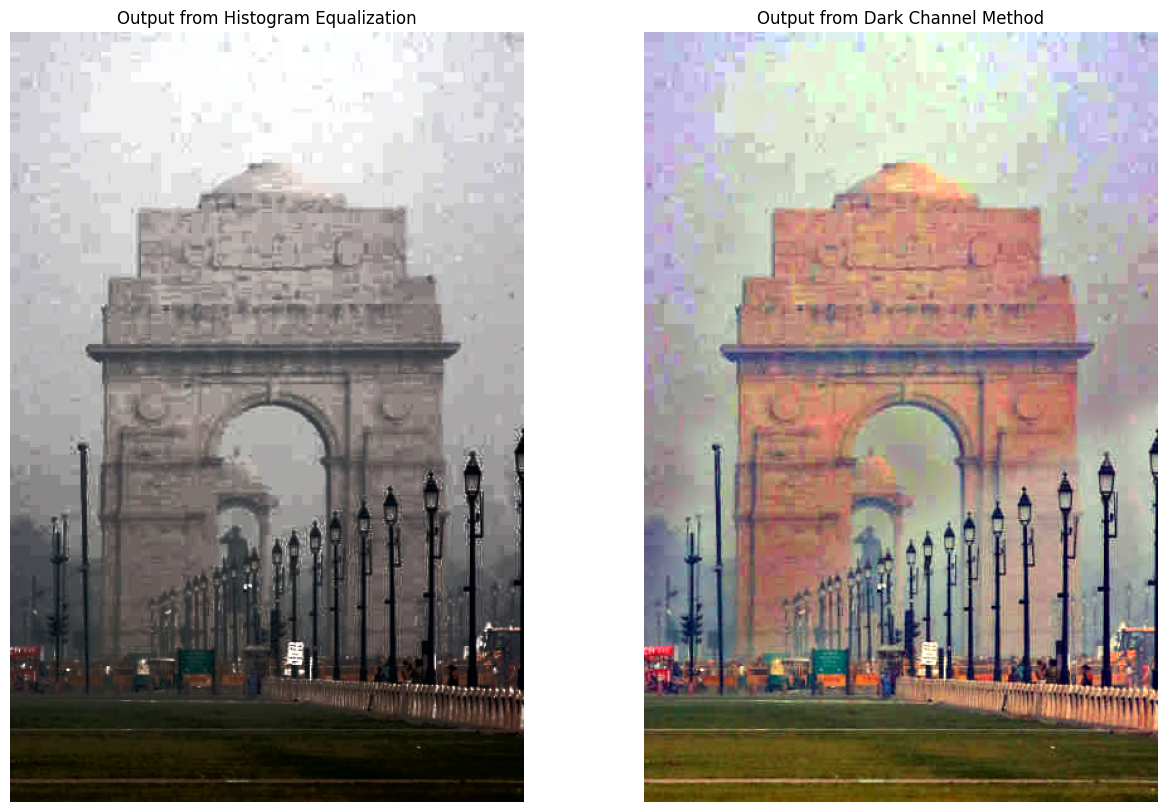

In [17]:
J = histEqual(cv2.imread("/content/a.jpg"))
fig=plt.figure(figsize=(15,10))
ax=fig.add_subplot(121)
ax.imshow(J[...,::-1])
ax.set_title("Output from Histogram Equalization")
ax.axis('off')
ax=fig.add_subplot(122)
ax.imshow(cb_J[...,::-1])
ax.set_title("Output from Dark Channel Method")
ax.axis('off')
plt.show()